Mass Spring Model
------------------

A mass sping model is a decent approximation for cloth or any thin shelled material.  The model is made up of a mesh of nodes interconnected with edges.  The nodes have a mass $m$ and the edges have a spring contant $k$, length $len$, and a natural resting length $len_{rest}$.  The force of gravity is included with, using the normal gravitational constant, $g=<0,0,-9.8>$.

Thus the force on each node is:
$$F = mg + \sum_{springs} k(len - len_{rest})$$

Then Newton's second equation provides the differential equations to update the position of the nodes, $x$.  A damepning factor $\lambda$ is included to approximate the effect of friction.  We use two coupled first order equations for each node:
$$\frac{dx}{dt} = v$$
$$\frac{dv}{dt} = \frac{F - \lambda v}{m}$$

Given this formulation of differential equations an initial velocity must be supplied, zero is the natural choice.

In order to solve the differential equations euler's method is used.

In [ ]:
# Python IMPORTS
import numpy as np
import scipy as sp
import scipy.integrate

def ndstr(a, format_string ='{0:.3f}'):
    return [format_string.format(v,i) for i,v in enumerate(a)]

In [246]:
# ODES   - Ordinary Differential Equations

# t - time [s]
# X = [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z]  [m, m/s]
# forceVector - [force_x, force_y, force_z]       [N]
# dampeningFactor - dampening of force based on velocity
# links - Link class objects
# particle - this mass particle and metadata
#
def newtonEq(t, X, mass, forceVector, dampeningFactor, particle):
    X_prime = np.zeros(len(X));
    # position
    X_prime[0] = X[3];
    X_prime[1] = X[4];
    X_prime[2] = X[5];
    
    # velocity
    springforce = np.zeros(3);
    for link in particle.links:
        springforce += link.getForce(particle);
    X_prime[3] = ((particle.force[0] + springforce[0]) - dampeningFactor*X[3])/mass;   # model adds velocity dampening in place
    X_prime[4] = ((particle.force[1] + springforce[1]) - dampeningFactor*X[4])/mass;   # of internal friction
    X_prime[5] = ((particle.force[2] + springforce[2]) - dampeningFactor*X[5])/mass + -9.81;  # add gravity
    return X_prime;

# wrapper for numerical intergration
def integrate(t, dt, particle, numSteps=20):  
    method = sp.integrate.ode(newtonEq).set_integrator('dopri5', nsteps=numSteps);  # runge-katta 4-5 method
    method.set_initial_value(particle.posvel, t).set_f_params( particle.mass, particle.force, particle.dampeningFactor, particle);
    return method.integrate(method.t+dt);


In [364]:
# mesh class design influenced by https://github.com/valorcurse/cloth-simulation
#  WTFPL license - http://www.wtfpl.net/

class Particle:
    def __init__(self, posvel, mass, dampeningFactor):
        self.posvel = posvel
        self.lastPosvel = posvel
        self.mass = mass
        self.dampeningFactor = dampeningFactor;
        self.force =  np.zeros(3);
        self.anchored = False
        self.links = []
    
    def update(self, et, dt):
        if(not self.anchored):
            self.posvel = integrate(et, dt, self);
        
    def applyForce(self, vec3d):
        self.force = vec3d;
        
    def applyConstraints(self, circleCenters, circleRadius):
        # body collision
        #    if collided, move to surface and zero out velocity normal to that move
        #    check the full set of circles
        for i in range(len(circleRadius)):
            center = circleCenters[i]
            relLoc = np.array(((self.posvel[0]-center[0]), (self.posvel[1]-center[1]),(self.posvel[2]-center[2])))
            dist = np.linalg.norm(relLoc)
            if dist < circleRadius[i]:
                # we have collided and are currently inside the circle
                # move to surface along relative position vector
                self.posvel[:3] = center + relLoc * circleRadius[i] / dist
                # reset velocity, zeroing component in relative position direction
                self.posvel[3:] = np.cross(self.posvel[3:], relLoc / dist)
                
        
        for link in self.links:
            link.applyConstraints()
        
class Link:
    def __init__(self, part1, part2, restingDist, k):
        self.particle1 = part1
        self.particle2 = part2
        self.restingDistance = restingDist
        self.springConstant = k
        
    def getForce(self, particle):
        # direction is with respect to particle in the argument
        #   spring force is always directed along the length of the spring
        #   either towards or away from the center
        if(particle == self.particle1):
            part1 = self.particle1;
            part2 = self.particle2;
        elif(particle == self.particle2):
            part2 = self.particle1;
            part1 = self.particle2;
        else:
            raise ValueError('a bad thing happened, the specified particle to use as reference location is not in this Link')
    
        # displacement in 1D
        dz = part2.posvel[2] - part1.posvel[2];
        dy = part2.posvel[1] - part1.posvel[1];
        dx = part2.posvel[0] - part1.posvel[0];
        currLen = np.sqrt(dx * dx + dy * dy + dz * dz);
        # spring force
        mag_force = self.springConstant * (currLen - self.restingDistance);    # hooke's law F = kx
        
        # place force in the direction of the spring
        springForce =  np.zeros(3);
        if(currLen > 0):
            # being length 0 should be vanishingly rare chance, so we'll just skip it for a step
            springForce[0] = (dx/currLen) * mag_force;
            springForce[1] = (dy/currLen) * mag_force;
            springForce[2] = (dz/currLen) * mag_force;
        
        return springForce
    
    def getLen(self, particle):
        if(particle == self.particle1):
            part1 = self.particle1;
            part2 = self.particle2;
        elif(particle == self.particle2):
            part2 = self.particle1;
            part1 = self.particle2;
        else:
            raise ValueError('a bad thing happened, the specified particle to use as reference location is not in this Link')
        
        dz = part2.posvel[2] - part1.posvel[2];
        dy = part2.posvel[1] - part1.posvel[1];
        dx = part2.posvel[0] - part1.posvel[0];
        return np.sqrt(dx * dx + dy * dy + dz * dz);
    
    def getDir(self, particle):
        if(particle == self.particle1):
            part1 = self.particle1;
            part2 = self.particle2;
        elif(particle == self.particle2):
            part2 = self.particle1;
            part1 = self.particle2;
        else:
            raise ValueError('a bad thing happened, the specified particle to use as reference location is not in this Link')
        
        dz = part2.posvel[2] - part1.posvel[2];
        dy = part2.posvel[1] - part1.posvel[1];
        dx = part2.posvel[0] - part1.posvel[0];
        mag = np.sqrt(dx * dx + dy * dy + dz * dz);
        dirVec = np.zeros(3);
        dirVec[0] = dx/mag;
        dirVec[1] = dy/mag;
        dirVec[2] = dz/mag;
        return dirVec;
        
    
    def applyConstraints(self):
        # do nothing for now
        pass






In [70]:
# simple test of integrator
part = Particle(np.array((0,0,0,0,0,0)), 0.01, 0.005);
t0 = 0;
posvel = integrate(t0, t0+1, part, 100)
print posvel
print ''
t0 = 0;
part.posvel = posvel;
posvel = integrate(t0, t0+1, part, 100)
print posvel
print''


[ 0.          0.         -4.18026313  0.          0.         -7.71986843]

[  0.           0.         -14.43558945   0.           0.         -12.40220528]



In [110]:
# build a test of our cloth model

squareSize = 0.1;
width = 10;  # points
height = 12; # points

k = 100;
mass = .197*squareSize*squareSize;  # 197 g/ m^2
dampening = 0.005;

points = [Particle(np.array((0.0, 0.0, 0.0, 0.0, 0.0, 0.0)), mass, dampening) for x in xrange(width*height)]
for point in range(0, len(points)):
    points[point].posvel[1] = (point % width) * squareSize;  
    points[point].posvel[0] = np.floor(point / width) * squareSize;
    
    # Link to point to the right (rows)
    if ((point+1) <= len(points) and (point+1) % width != 0):
        points[point].links.append(Link(points[point], points[(point+1)], squareSize, k))

    # Link to point above (columns)
    if ((point+width) < len(points)):
        points[point].links.append(Link(points[point], points[point+width], squareSize, k))
        
    # Link to point to the left (rows)
    if ((point) > 0 and point % width != 0):
        points[point].links.append(Link(points[point], points[(point-1)], squareSize, k))

    # Link to point below (columns)
    if ((point-width) >= 0):
        points[point].links.append(Link(points[point], points[point-width], squareSize, k))

# Pin the top two points
points[0].anchored = True
points[width-1].anchored = True

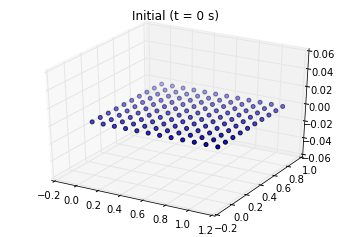

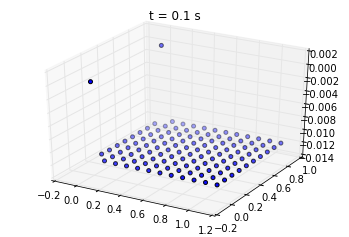

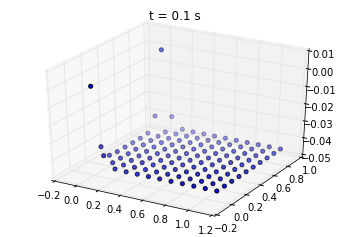

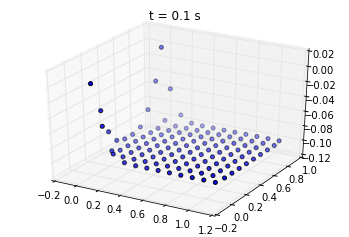

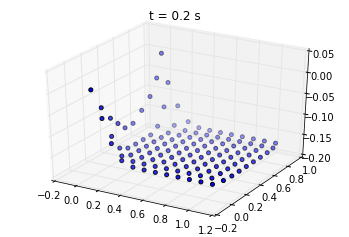

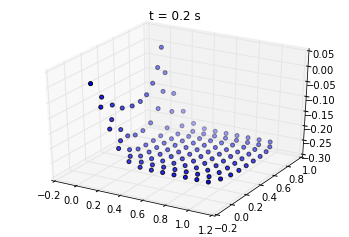

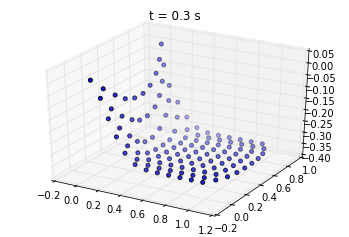

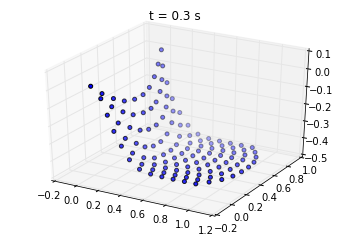

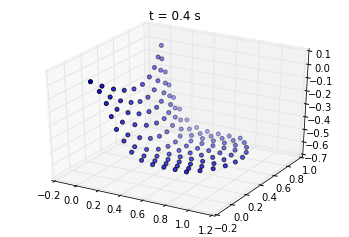

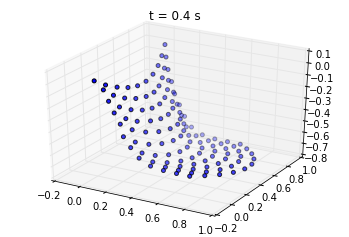

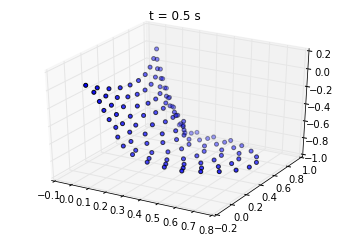

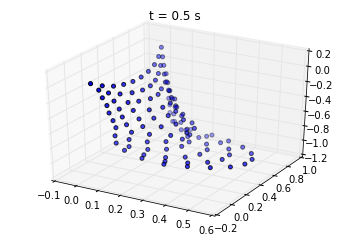

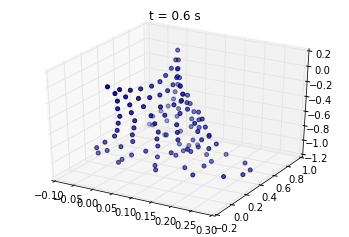

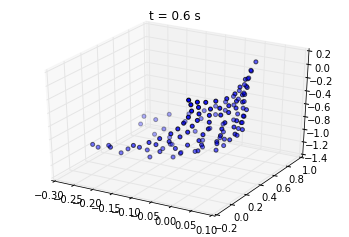

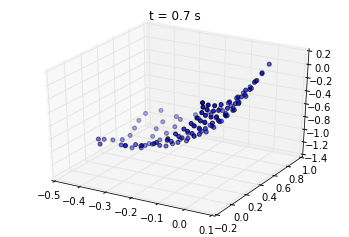

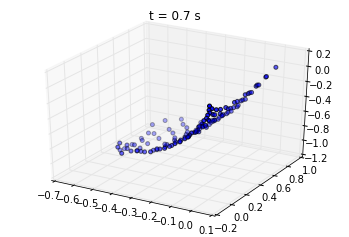

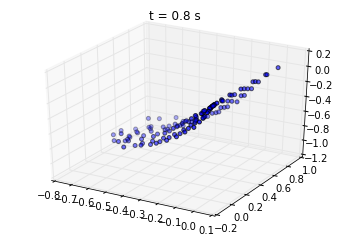

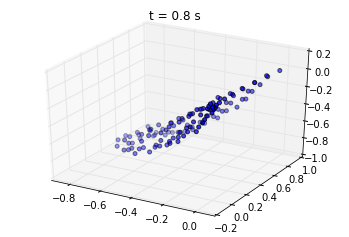

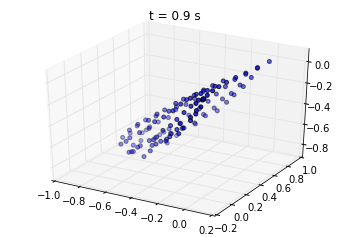

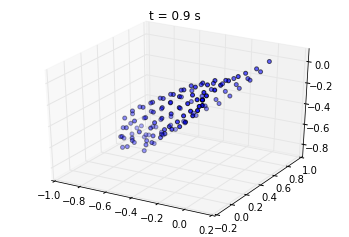

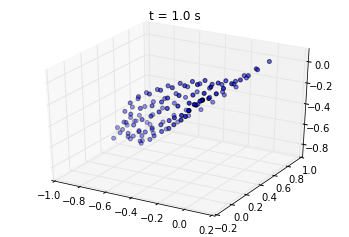

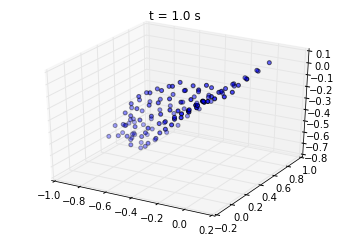

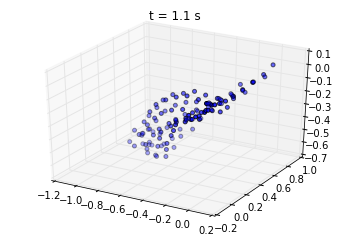

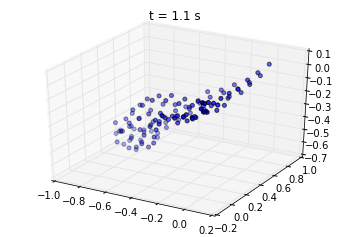

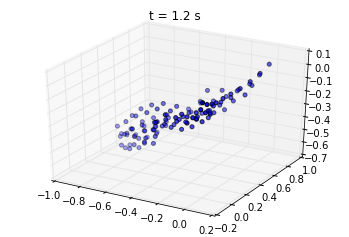

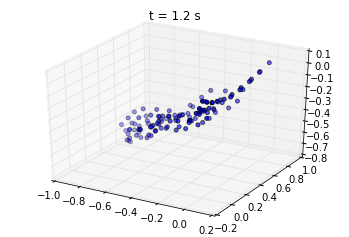

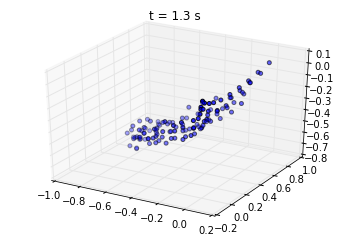

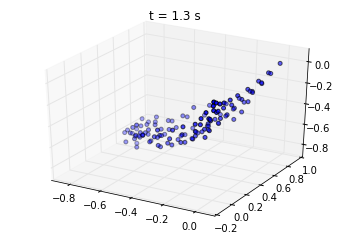

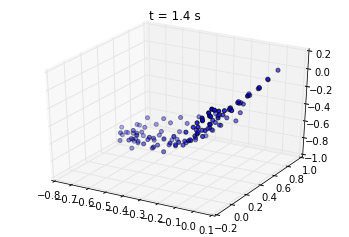

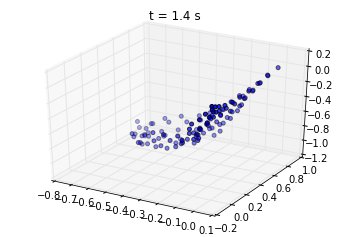

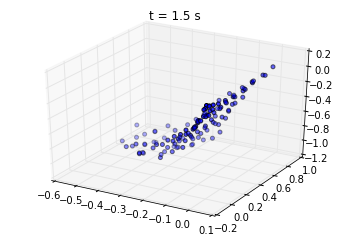

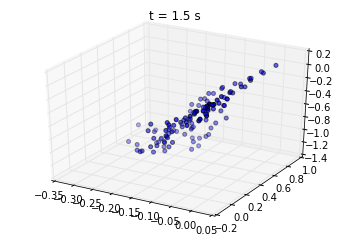

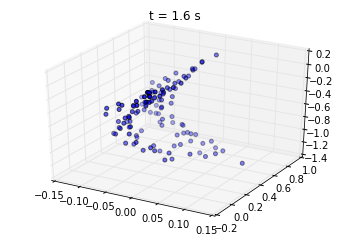

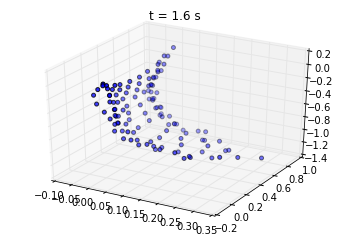

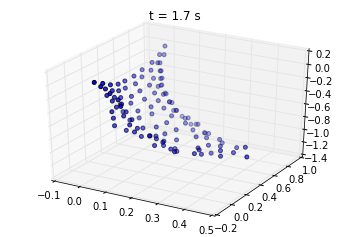

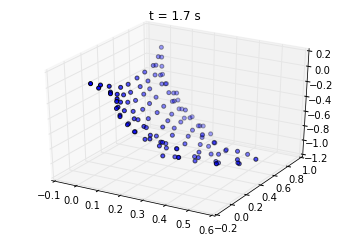

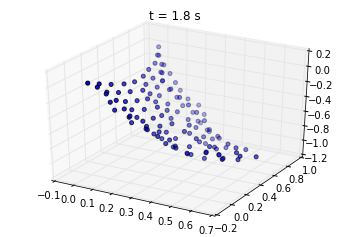

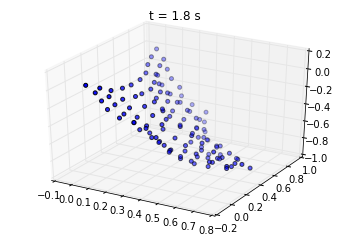

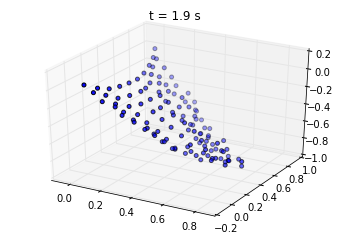

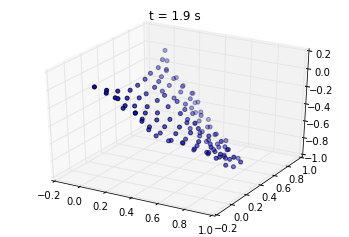

KeyboardInterrupt: 

In [79]:
from JSAnimation import IPython_display
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

# demonstration of our physcis engine with cloth,  lots of plots generated

def plotPoints(points):
    xs = np.zeros(len(points));
    ys = np.zeros(len(points));
    zs = np.zeros(len(points));
    for pointIdx in range(len(points)):
        xs[pointIdx] = points[pointIdx].posvel[0]
        ys[pointIdx] = points[pointIdx].posvel[1]
        zs[pointIdx] = points[pointIdx].posvel[2]
    plot = ax.scatter(xs, ys, zs, s=16)
    #for link in point.links:
    #    plot = ax.plot([link.particle1.posvel[0], link.particle2.posvel[0]], [link.particle1.posvel[1], 
    #                    link.particle2.posvel[1]], [link.particle1.posvel[2], link.particle2.posvel[2]])   
    return plot

simtime = 0;
timestep = 0.0001;
endtime = 10;

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('Initial (t = 0 s)')
plt.show()

counter = 0;
while simtime < endtime:
    for point in points:
        point.applyConstraints();

    for point in points:
        point.update(simtime, timestep);
    simtime = simtime + timestep;
    counter = counter + 1;
    if(counter % 500 == 0):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plotPoints(points)
        plt.title('t = {:.1f} s'.format(simtime))
        plt.show()
        
        #printIdx = 11
        #print 'posvel = {}'.format(ndstr(points[1].posvel))
        #springforce = np.zeros(3);
        #for link in points[printIdx].links:
        #    springDir = link.getDir(points[printIdx])
        #    springLen = link.getLen(points[printIdx])
        #    print '\tlink posvel = {}, posvel2 = {} \n\t\twith len {} and dir = {}\n\t\tso force contribution = {}'.format(ndstr(link.particle1.posvel), 
        #                    ndstr(link.particle2.posvel), springLen, ndstr(springDir), ndstr(springDir * 100 * (springLen - 0.1)))
        #    springforce += link.getForce(points[printIdx]);
        #print 'spring force = {}'.format(ndstr(springforce))
        #print ''
         

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('end sim')
plt.show()

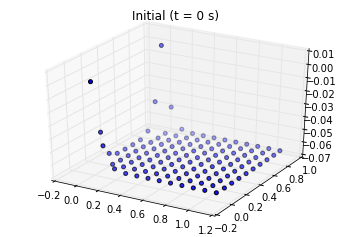

In [151]:
from JSAnimation import IPython_display   # requires JSAnimation library to be installed - setup.py in the lib folder
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  


# demonstration of our physics engine with cloth

simtime = 0;
timestep = 0.0001;
endtime = 3;

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('Initial (t = 0 s)')
plt.show()

counter = 0;
savePointIdx = 0;
its = 500;
savePoints = int((endtime - simtime) / timestep / its);
xs = np.zeros((savePoints, len(points)));
ys = np.zeros((savePoints, len(points)));
zs = np.zeros((savePoints, len(points)));
timeHist =  np.zeros(savePoints);
while simtime < endtime:
    for point in points:
        point.applyConstraints();

    for point in points:
        point.update(simtime, timestep);
    simtime = simtime + timestep;
    counter = counter + 1;
    
    if(counter % its == 0):
        timeHist[savePointIdx] = simtime;
        for pointIdx in range(len(points)):
            xs[savePointIdx, pointIdx] = points[pointIdx].posvel[0]
            ys[savePointIdx, pointIdx] = points[pointIdx].posvel[1]
            zs[savePointIdx, pointIdx] = points[pointIdx].posvel[2]
        savePointIdx = savePointIdx + 1;
            
    

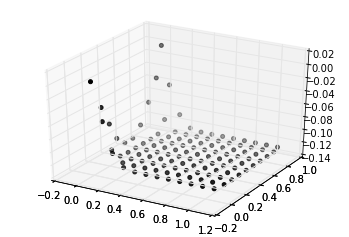

In [153]:
# create an animation demonstrating the cloth physics model
def animateFn(i, xs, ys, zs, timeHist, sc, hText):
    #print len(xs[:,i])
    #sc._offsets3d = (xs[i,:], ys[i,:], zs[i,:])
    hText.set_text('{:.3f} s'.format(timeHist[i]))
    ax.clear()
    sc = ax.scatter(ix, iy, iz, c='k', s=16)
    return sc,

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ix = xs[0,:]
iy = ys[0,:]
iz = zs[0,:]
sc = ax.scatter(ix, iy, iz, c='k', s=16)
hText = ax.text(0, 0, .1, 'init', None)
anim = animation.FuncAnimation(fig, animateFn, frames=savePoints, interval=100, 
                               fargs=(xs, ys, zs, timeHist, sc, hText), blit=False)

(60L, 120L, 3L)



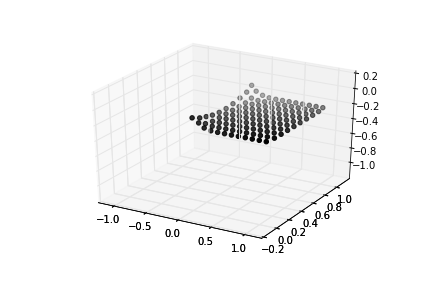
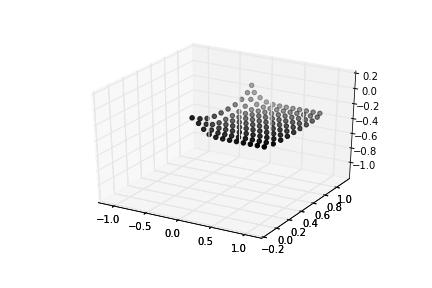
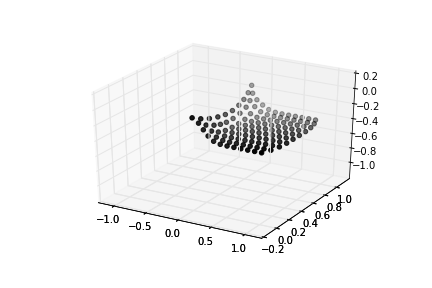
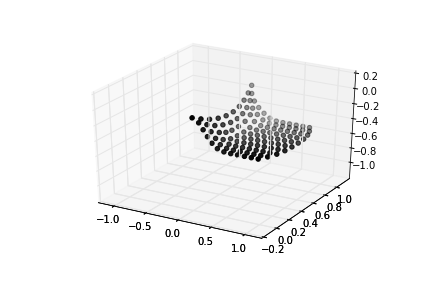
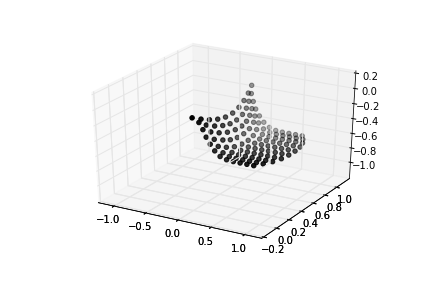
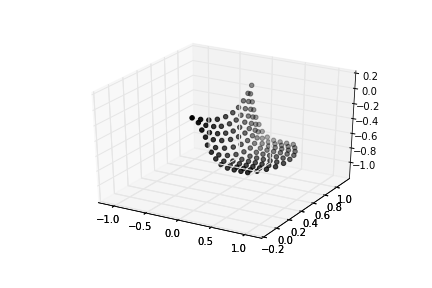
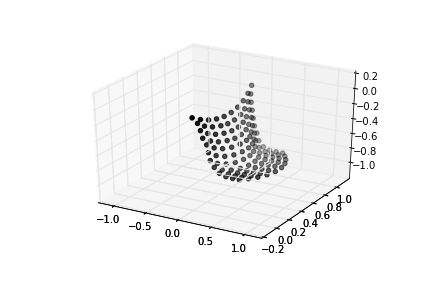
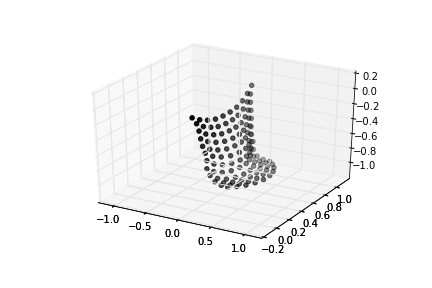
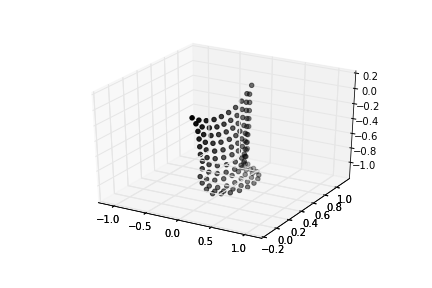
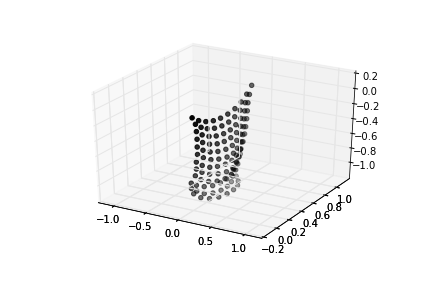
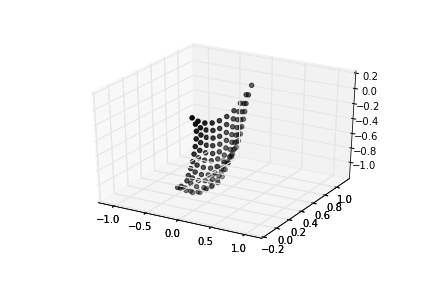
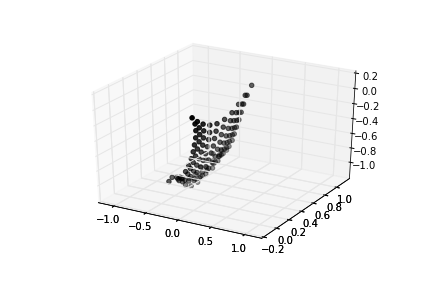
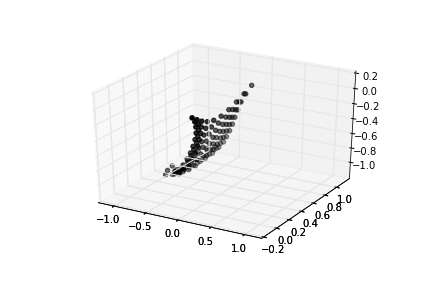
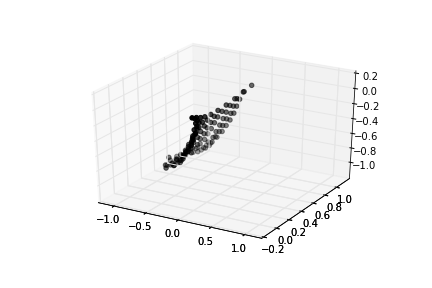
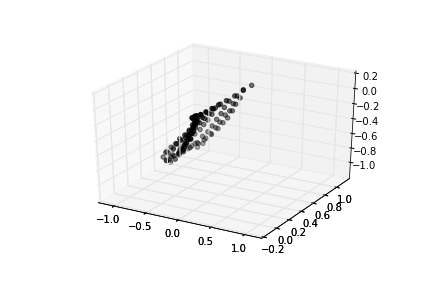
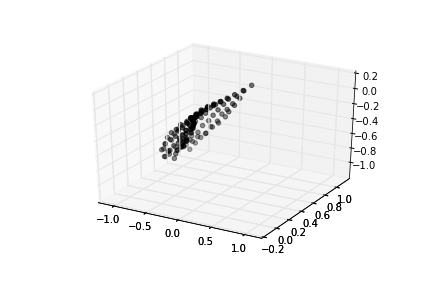
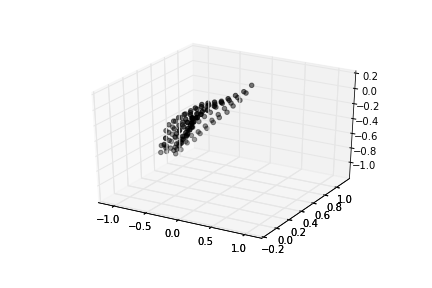
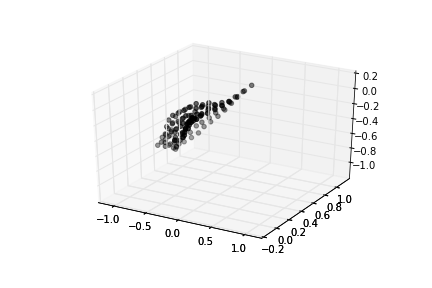
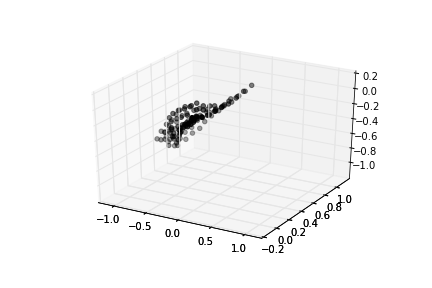
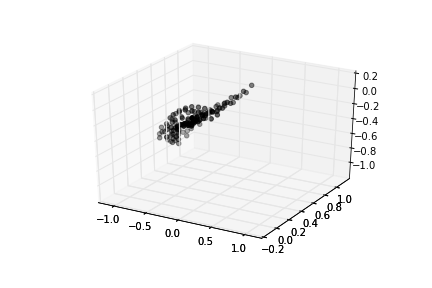
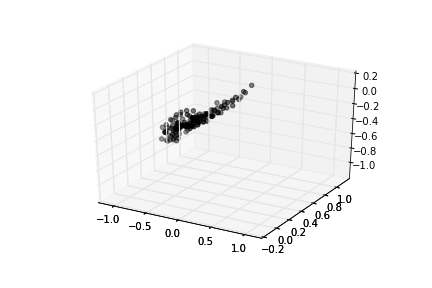
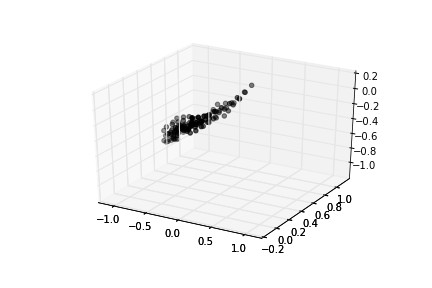
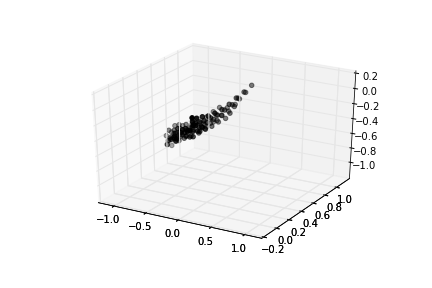
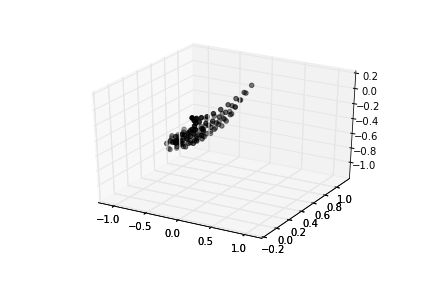
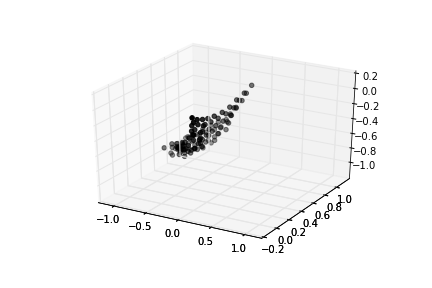
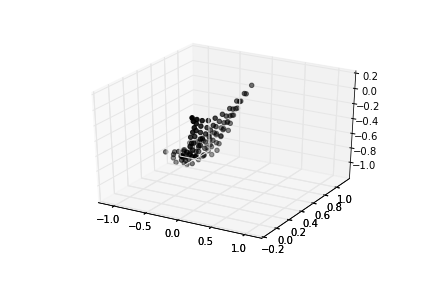
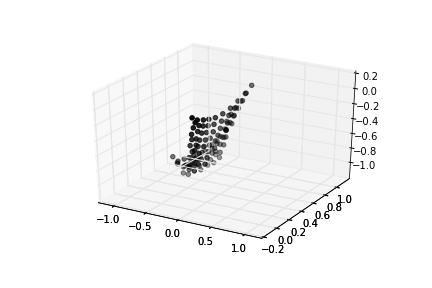
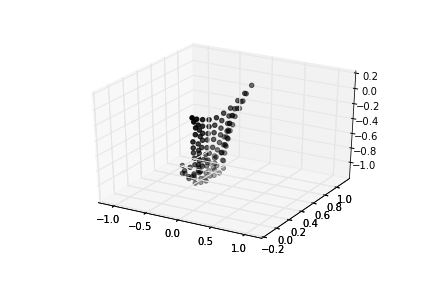
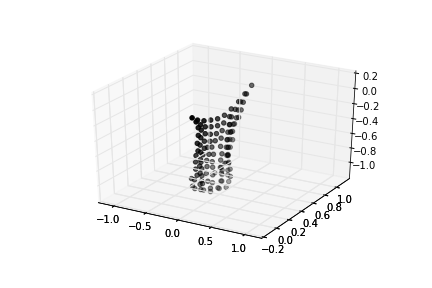
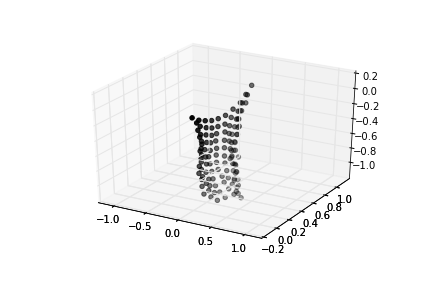
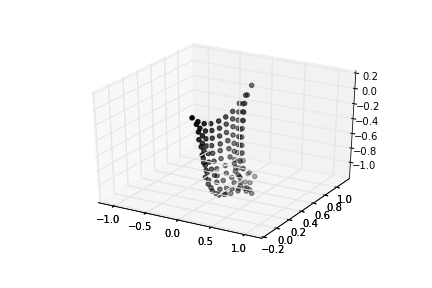
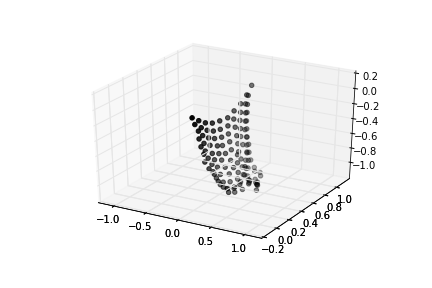
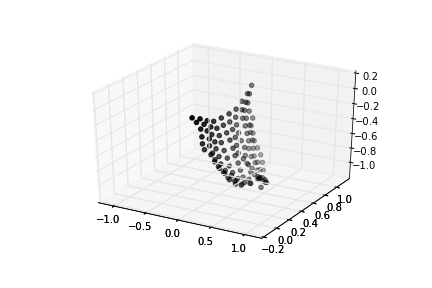
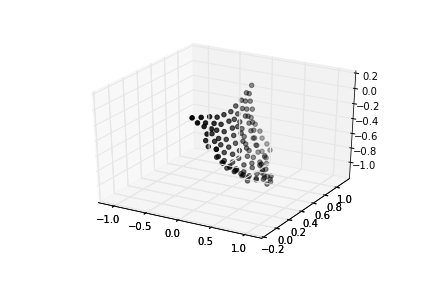
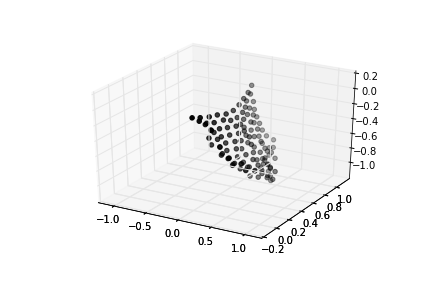
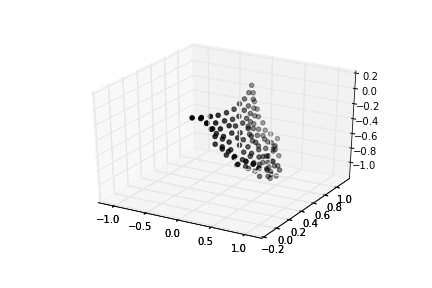
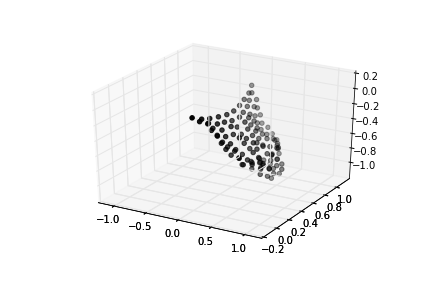
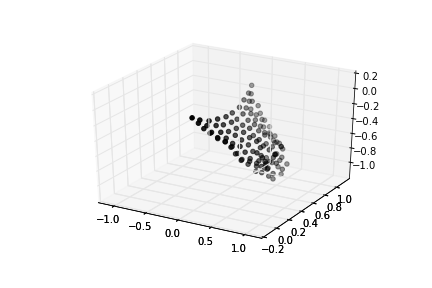
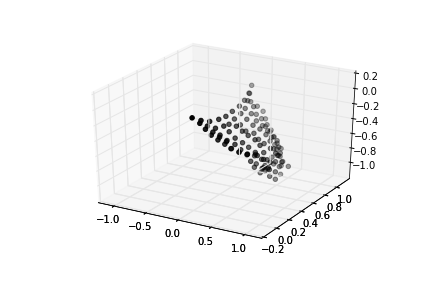
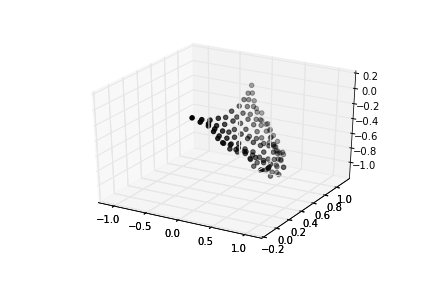
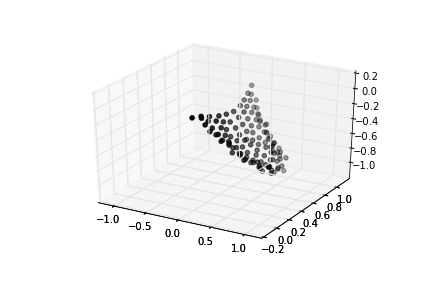
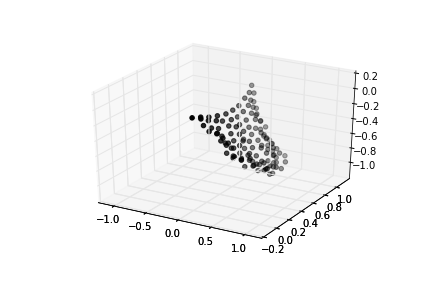
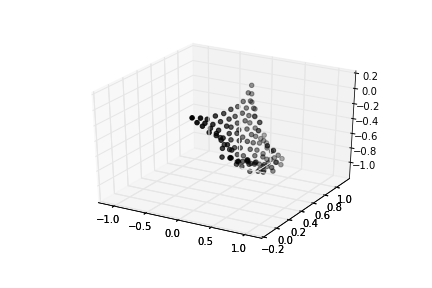
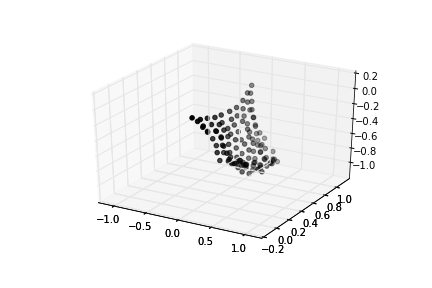
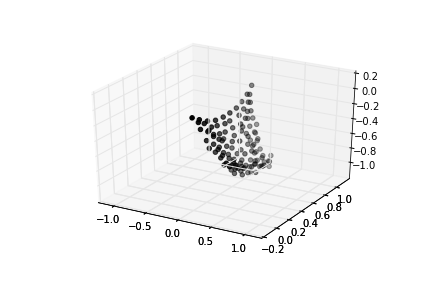
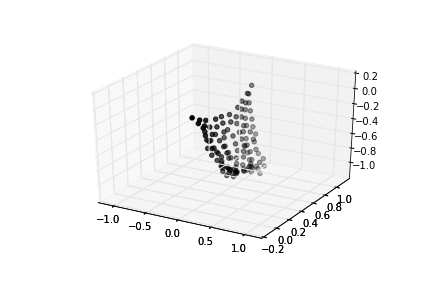
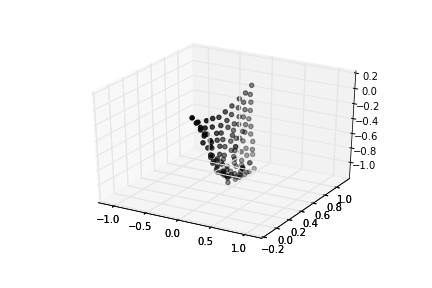
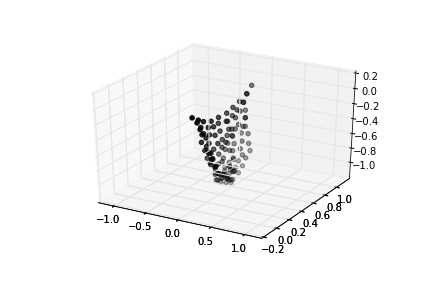
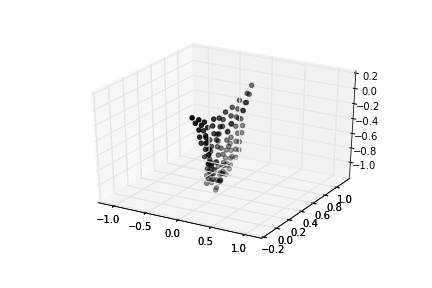
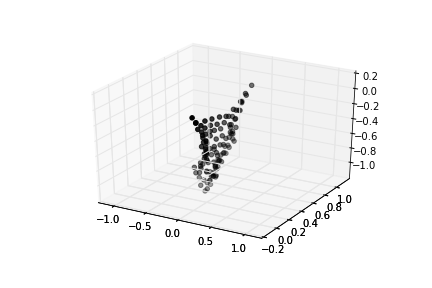
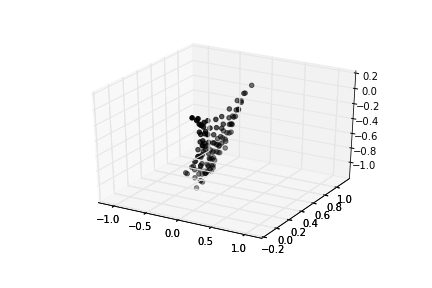
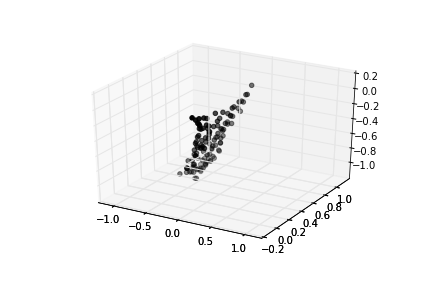
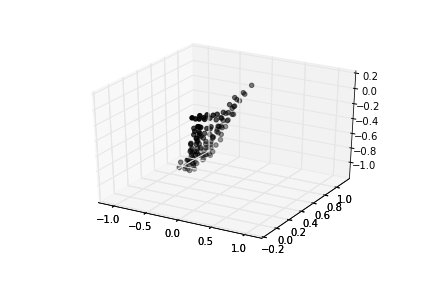
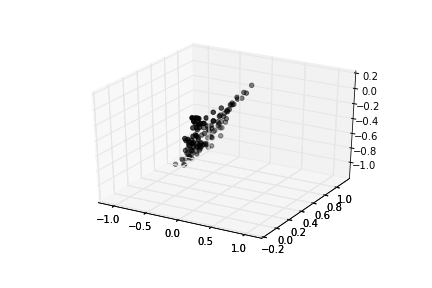
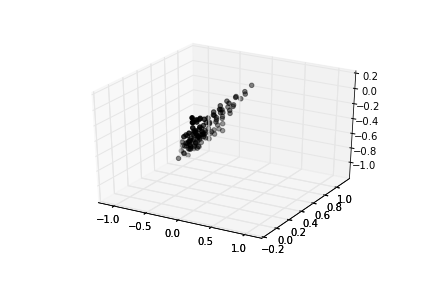
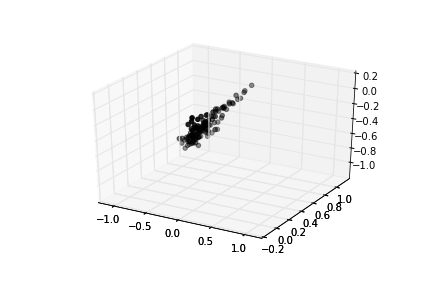
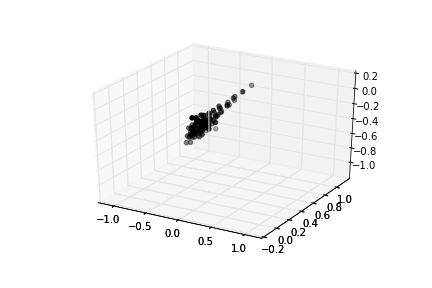
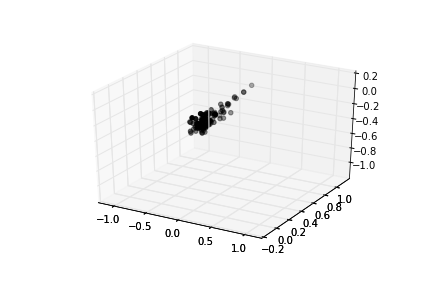
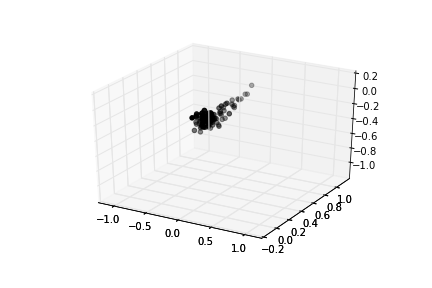
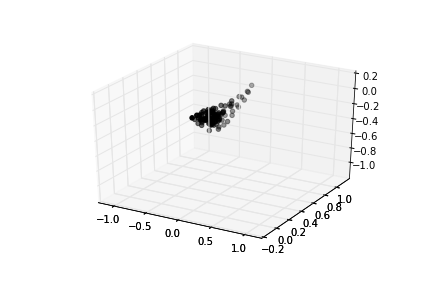

In [166]:
# create a simple animation demonstrating the cloth physics model

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

numframes = 60
numPoints = 120;
#data = np.random.rand(numframes, numPoints, 3)  # a (time, position) array
data = np.zeros((numframes, numPoints, 3))
print data.shape
data[:,:,0] = xs;
data[:,:,1] = ys;
data[:,:,2] = zs;

ix = data[0,:,0]
iy = data[0,:,1]
iz = data[0,:,2]
#print ix
sc = ax.scatter(ix, iy, iz, c='k')
ax.set_xlim3d(-1.2,1.2)
ax.set_ylim3d(-0.2,1.2)
ax.set_zlim3d(-1.2,0.2)

def animate(i, data_x, data_y, data_z, sc):
    #print len(data[i,:,0])
    
    # this works
    #sc._offsets3d = (data_x[i,:], data_y[i,:], data_z[i,:])
    
    # so does this
    ax.clear()
    sc = ax.scatter(data_x[i,:], data_y[i,:], data_z[i,:], c='k')
    ax.set_xlim3d(-1.2,1.2)
    ax.set_ylim3d(-0.2,1.2)
    ax.set_zlim3d(-1.2,0.2)
    return sc,

animation.FuncAnimation(fig, animate,  frames=numframes, interval=100, blit=False, fargs=(data[:,:,0], data[:,:,1], data[:,:,2],sc))

Cotton properties
http://cdn.intechopen.com/pdfs-wm/12243.pdf

In [270]:
def getXY(part1, part2):
    # xy, distance between two particles
    x1 = part1.posvel[0];
    x2 = part2.posvel[0];
    y1 = part1.posvel[1];
    y2 = part2.posvel[1];
    
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

448


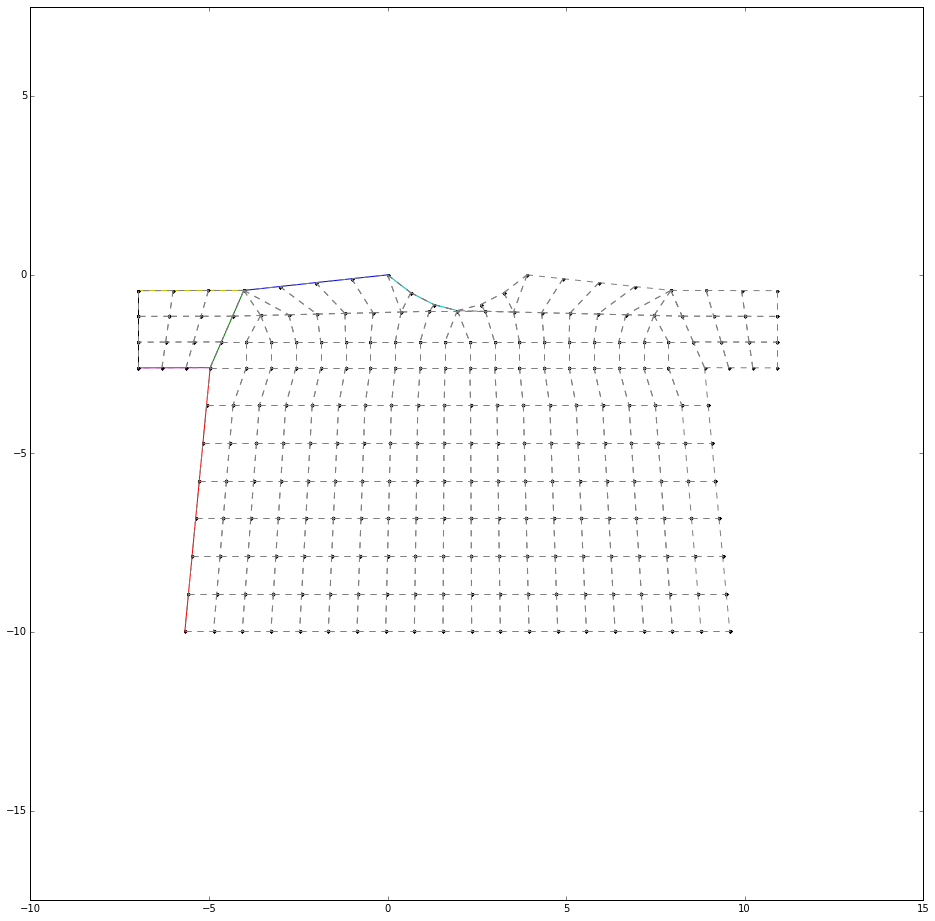

In [400]:
# shirt meshes

# have to hand code the mesh generation  :(

from scipy import interpolate

def generateShirtMesh(k, density, dampening, shoulder, sleeveBottom, sleeveEnd, shirtBottom, collarMid, debugPlot=False):
    mass = density / 100;  # approx 100 points per m^2
    
    topLineF = scipy.interpolate.interp1d((0, shoulder[0]), (0, shoulder[1]))
    topLinex = np.linspace(shoulder[0],0, 5)
    topLiney =  topLineF(topLinex)
    if(debugPlot):
        plt.plot(topLinex, topLiney, '.-')
        plt.hold
    
    
    SleeveLineF = scipy.interpolate.interp1d((shoulder[0], sleeveBottom[0]), (shoulder[1], sleeveBottom[1]))
    SleeveLinex = np.linspace(shoulder[0], sleeveBottom[0], 4)
    SleeveLiney =  SleeveLineF(SleeveLinex)
    if(debugPlot):
        plt.plot(SleeveLinex, SleeveLiney, '.-')
    
    sideF = scipy.interpolate.interp1d((sleeveBottom[0], shirtBottom[0]), (sleeveBottom[1], shirtBottom[1]))
    sidex = np.linspace(sleeveBottom[0], shirtBottom[0], 8)
    sidey =  sideF(sidex)
    if(debugPlot):
        plt.plot(sidex, sidey, '.-')
    
    collarCtrl = np.array((collarMid[0]/2, 3*collarMid[1]/4))
    CollarF = scipy.interpolate.interp1d((0, collarCtrl[0], collarMid[0]), (0, collarCtrl[1], collarMid[1]))
    collarx = np.linspace(0, collarMid[0], 4)
    collary =  CollarF(collarx)
    if(debugPlot):
        plt.plot(collarx, collary, '.-')
    
    sleeveBottomF = scipy.interpolate.interp1d((sleeveBottom[0], sleeveEnd[0]), (sleeveBottom[1], sleeveEnd[1]))
    sleeveBotx = np.linspace(sleeveBottom[0], sleeveEnd[0], 4)
    sleeveBoty =  sleeveBottomF(sleeveBotx)
    if(debugPlot):
        plt.plot(sleeveBotx, sleeveBoty, '.-')
    
    sleeveTopF = scipy.interpolate.interp1d((shoulder[0], sleeveEnd[0]), (shoulder[1], shoulder[1]-(sleeveBottom[1] - sleeveEnd[1])))
    sleeveTopx = np.linspace(shoulder[0], sleeveEnd[0], 4)
    sleeveTopy =  sleeveTopF(sleeveTopx)
    if(debugPlot):
        plt.plot(sleeveTopx, sleeveTopy, '.-')
    
    sleeveEndx = np.linspace(sleeveEnd[0], sleeveEnd[0], 4)
    sleeveEndy = np.linspace(shoulder[1]-(sleeveBottom[1] - sleeveEnd[1]), sleeveEnd[1], 4)
    if(debugPlot):
        plt.plot(sleeveEndx, sleeveEndy, '.-')
    

   
    points = []
    links = []    # a listing of pairs to join as links later

    yFlip = collarx[3]
    # bottom edge of the wearers right sleeve
    rightSleeveIdx = 0;
    points.append(Particle(np.array((sleeveBotx[0], sleeveBoty[0], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((sleeveBotx[1], sleeveBoty[1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((sleeveBotx[2], sleeveBoty[2], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((sleeveBotx[3], sleeveBoty[3], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    # front and back of the sleeve
    i=0
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=1
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=2
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=3
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3, i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=0
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=1
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=2
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=3
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3, i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    #top edge
    points.append(Particle(np.array((sleeveTopx[0], sleeveTopy[0], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((sleeveTopx[1], sleeveTopy[1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((sleeveTopx[2], sleeveTopy[2], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((sleeveTopx[3], sleeveTopy[3], 0.0, 0.0, 0.0, 0.0)), mass, dampening))

    sleeveStartIdx = rightSleeveIdx;
    for i in range(3):
        # connect bottom row together
        links.append((sleeveStartIdx+i, sleeveStartIdx+i+1))
    for i in range(4):
        # up link
        links.append((sleeveStartIdx+i, sleeveStartIdx+12+2*i))
        links.append((sleeveStartIdx+i, sleeveStartIdx+13+2*i))
        if(i < 3):
            # right link
            links.append((sleeveStartIdx+12+2*i, sleeveStartIdx+12+2*(i+1)))
            links.append((sleeveStartIdx+13+2*i, sleeveStartIdx+13+2*(i+1)))
    for i in range(4):
        # up link
        links.append((sleeveStartIdx+12+2*i, sleeveStartIdx+4+2*i))
        links.append((sleeveStartIdx+13+2*i, sleeveStartIdx+5+2*i))
        if(i < 3):
            # right link
            links.append((sleeveStartIdx+4+2*i, sleeveStartIdx+4+2*(i+1)))
            links.append((sleeveStartIdx+5+2*i, sleeveStartIdx+5+2*(i+1)))
    for i in range(4):
        # up link
        links.append((sleeveStartIdx+20+i, sleeveStartIdx+4+2*i))
        links.append((sleeveStartIdx+20+i, sleeveStartIdx+5+2*i))
        if(i < 3):
            # right link
            links.append((sleeveStartIdx+20+i, sleeveStartIdx+20+i+1))
    
    
    # left sleeve
    leftSleeveIdx = len(points)
    # bottom edge of the wearers right sleeve
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveBotx[0]), sleeveBoty[0], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveBotx[1]), sleeveBoty[1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveBotx[2]), sleeveBoty[2], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveBotx[3]), sleeveBoty[3], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    # front and back of the sleeve
    i=0
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=1
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=2
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=3
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[1] / 3 + (3-i) * SleeveLinex[1]/3)), i * sleeveEndy[1] / 3 + (3-i) * SleeveLiney[1]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=0
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=1
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=2
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    i=3
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-(i * sleeveEndx[2] / 3 + (3-i) * SleeveLinex[2]/3)), i * sleeveEndy[2] / 3 + (3-i) * SleeveLiney[2]/3, -1, 0.0, 0.0, 0.0)), mass, dampening))
    # top edge
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveTopx[0]), sleeveTopy[0], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveTopx[1]), sleeveTopy[1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveTopx[2]), sleeveTopy[2], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-sleeveTopx[3]), sleeveTopy[3], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    sleeveStartIdx = leftSleeveIdx;
    for i in range(3):
        # connect bottom row together
        links.append((sleeveStartIdx+i, sleeveStartIdx+i+1))
    for i in range(4):
        # up link
        links.append((sleeveStartIdx+i, sleeveStartIdx+12+2*i))
        links.append((sleeveStartIdx+i, sleeveStartIdx+13+2*i))
        if(i < 3):
            # right link
            links.append((sleeveStartIdx+12+2*i, sleeveStartIdx+12+2*(i+1)))
            links.append((sleeveStartIdx+13+2*i, sleeveStartIdx+13+2*(i+1)))
    for i in range(4):
        # up link
        links.append((sleeveStartIdx+12+2*i, sleeveStartIdx+4+2*i))
        links.append((sleeveStartIdx+13+2*i, sleeveStartIdx+5+2*i))
        if(i < 3):
            # right link
            links.append((sleeveStartIdx+4+2*i, sleeveStartIdx+4+2*(i+1)))
            links.append((sleeveStartIdx+5+2*i, sleeveStartIdx+5+2*(i+1)))
    for i in range(4):
        # up link
        links.append((sleeveStartIdx+20+i, sleeveStartIdx+4+2*i))
        links.append((sleeveStartIdx+20+i, sleeveStartIdx+5+2*i))
        if(i < 3):
            # right link
            links.append((sleeveStartIdx+20+i, sleeveStartIdx+20+i+1))
    
    
    #topEdge
    topEdgeIdx = len(points)
    points.append(Particle(np.array((topLinex[0], topLiney[0], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((topLinex[1], topLiney[1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((topLinex[2], topLiney[2], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((topLinex[3], topLiney[3], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((topLinex[4], topLiney[4], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    collarStartIdx = len(points)
    #print (collarStartIdx-1)
    points.append(Particle(np.array((collarx[1], collary[1], 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((collarx[1], collary[1], -1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((collarx[2], collary[2], 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((collarx[2], collary[2], -1, 0.0, 0.0, 0.0)), mass, dampening))
    collarMidIdx = len(points)
    points.append(Particle(np.array((collarx[3], collary[3], 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((collarx[3], collary[3], -1, 0.0, 0.0, 0.0)), mass, dampening))
    collarBackIdx = len(points)
    points.append(Particle(np.array((yFlip+ (yFlip-collarx[2]), collary[2], 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-collarx[2]), collary[2], -1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-collarx[1]), collary[1], 1, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-collarx[1]), collary[1], -1, 0.0, 0.0, 0.0)), mass, dampening))
    topEdgeRejoin = len(points)
    #print topEdgeRejoin
    points.append(Particle(np.array((yFlip+ (yFlip-topLinex[4]), topLiney[4], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-topLinex[3]), topLiney[3], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-topLinex[2]), topLiney[2], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-topLinex[1]), topLiney[1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    points.append(Particle(np.array((yFlip+ (yFlip-topLinex[0]), topLiney[0], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    # 2nd line
    secLineIdx = len(points);
    secLineF = scipy.interpolate.interp1d((SleeveLinex[1], collarMid[0]), (SleeveLiney[1], collarMid[1]))
    secLinex = np.linspace(SleeveLinex[1], collarMid[0], 9)
    secLinex = secLinex[1:8]
    secLiney =  secLineF(secLinex)
    for i in range(len(secLinex)):
        # minus 1 since we can have already insert the collor midpoint
        points.append(Particle(np.array((secLinex[i], secLiney[i], 1.0, 0.0, 0.0, 0.0)), mass, dampening))
        points.append(Particle(np.array((secLinex[i], secLiney[i], -1.0, 0.0, 0.0, 0.0)), mass, dampening))
    secLineFlipIdx = len(points);
    for i in range(len(secLinex)):
        points.append(Particle(np.array((yFlip+ (yFlip-secLinex[len(secLinex)-1-i]), secLiney[len(secLinex)-1-i], 1.0, 0.0, 0.0, 0.0)), mass, dampening))
        points.append(Particle(np.array((yFlip+ (yFlip-secLinex[len(secLinex)-1-i]), secLiney[len(secLinex)-1-i], -1.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    # 3rd line
    thirdLineIdx = len(points);
    thirdLinex = np.linspace(SleeveLinex[2], yFlip+ (yFlip-SleeveLinex[2]), 20)
    thirdLinex = thirdLinex[1:19]
    thirdLiney = SleeveLiney[2]
    for i in range(len(thirdLinex)):
        points.append(Particle(np.array((thirdLinex[i], thirdLiney, 1.0, 0.0, 0.0, 0.0)), mass, dampening))
        points.append(Particle(np.array((thirdLinex[i], thirdLiney, -1.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    # fourth line
    fourthLineIdx = len(points);
    fourthLinex = np.linspace(SleeveLinex[2], yFlip+ (yFlip-SleeveLinex[2]), 20)
    fourthLinex = fourthLinex[1:19]
    fourthLiney = SleeveLiney[3]
    for i in range(len(fourthLinex)):
        points.append(Particle(np.array((fourthLinex[i], fourthLiney, 1.0, 0.0, 0.0, 0.0)), mass, dampening))
        points.append(Particle(np.array((fourthLinex[i], fourthLiney, -1.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    
    # seven more lines of the t shirt side
    fifthLineIdx = len(points)
    for j in range(7):
        xs = np.linspace(sidex[j+1], yFlip+ (yFlip-sidex[j+1]), 20)
        points.append(Particle(np.array((xs[0], sidey[j+1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
        for i in range(len(xs)-1):
            points.append(Particle(np.array((xs[i+1], sidey[j+1], 1.0, 0.0, 0.0, 0.0)), mass, dampening))
            points.append(Particle(np.array((xs[i+1], sidey[j+1], -1.0, 0.0, 0.0, 0.0)), mass, dampening))
        points.append(Particle(np.array((xs[len(xs)-1], sidey[j+1], 0.0, 0.0, 0.0, 0.0)), mass, dampening))
    
    # TOP ROW links
    # link the sleeve to shirt
    links.append((rightSleeveIdx+20, topEdgeIdx))
    for i in range(4):
        # right
        links.append((topEdgeIdx+i, topEdgeIdx+i+1))
    # split the collar
    links.append((topEdgeIdx+4, topEdgeIdx+5))
    links.append((topEdgeIdx+4, topEdgeIdx+6))
    for i in range(4):
    #    # right
        links.append((collarStartIdx+2*i, collarStartIdx+2*(i+1)))
        links.append((collarStartIdx+2*i+1, collarStartIdx+2*(i+1)+1))
    # recombine at the collar
    links.append((collarStartIdx+8, collarStartIdx+10))
    links.append((collarStartIdx+9, collarStartIdx+10))
    for i in range(4):
        # right
        links.append((topEdgeRejoin+i, topEdgeRejoin+1+i))
    # link other sleeve
    links.append((secLineIdx-1, leftSleeveIdx+5))
    
    # SECOND ROW links
    links.append((rightSleeveIdx+4, secLineIdx))
    links.append((rightSleeveIdx+5, secLineIdx+1))
    for i in range(13):
        # right
        links.append((secLineIdx+2*i, secLineIdx+2*(i+1)))
        links.append((secLineIdx+2*i+1, secLineIdx+2*(i+1)+1))
    # link the midpoint
    links.append((secLineIdx+2*7, collarMidIdx))
    links.append((secLineIdx+2*8, collarMidIdx+1))
    # link other sleeve
    links.append((secLineIdx+2*13, leftSleeveIdx+4))
    links.append((secLineIdx+2*13+1, leftSleeveIdx+5))
    # links down
    # deal with the odd number links first
    links.append((topEdgeIdx, secLineIdx))
    links.append((topEdgeIdx, secLineIdx+1))
    links.append((topEdgeRejoin+4, secLineFlipIdx+12))
    links.append((topEdgeRejoin+4, secLineFlipIdx+13))
    for i in range(5):    
        links.append((topEdgeIdx+i, secLineIdx+2*(i+1)))
        links.append((topEdgeIdx+i, secLineIdx+2*(i+1)+1))
        links.append((i+topEdgeRejoin, secLineFlipIdx+2*(i+1)))
        links.append((i+topEdgeRejoin, secLineFlipIdx+2*(i+1)+1))
    for i in range(2):    
        links.append((collarStartIdx+2*i, secLineIdx+2*(i+5)))
        links.append((collarStartIdx+2*i+1, secLineIdx+2*(i+5)+1))
    for i in range(2):    
        links.append((collarBackIdx+2*i, secLineFlipIdx+2*(i)))
        links.append((collarBackIdx+2*i+1, secLineFlipIdx+2*(i)+1))
    
    # THIRD ROW links
    links.append((rightSleeveIdx+12, thirdLineIdx))
    links.append((rightSleeveIdx+13, thirdLineIdx+1))
    for i in range(17):
        # right
        links.append((thirdLineIdx+2*i, thirdLineIdx+2*(i+1)))
        links.append((thirdLineIdx+2*i+1, thirdLineIdx+2*(i+1)+1))
    # link other sleeve
    links.append((thirdLineIdx+2*17, leftSleeveIdx+12))
    links.append((thirdLineIdx+2*17+1, leftSleeveIdx+13))
    # links down
    # deal with the odd number links first
    links.append((secLineIdx, thirdLineIdx))
    links.append((secLineIdx+1, thirdLineIdx+1))
    links.append((secLineFlipIdx+6*2, thirdLineIdx+17*2))
    links.append((secLineFlipIdx+6*2+1, thirdLineIdx+17*2+1))
    for i in range(7):    
        links.append((secLineIdx+2*i, thirdLineIdx+2*(i+1)))
        links.append((secLineIdx+2*i+1, thirdLineIdx+2*(i+1)+1))
    for i in range(7):    
        links.append((secLineFlipIdx+2*i, thirdLineIdx+2*(i+10)))
        links.append((secLineFlipIdx+2*i+1, thirdLineIdx+2*(i+10)+1))
    links.append((collarMidIdx, thirdLineIdx+2*8))
    links.append((collarMidIdx, thirdLineIdx+2*9))
    links.append((collarMidIdx+1, thirdLineIdx+2*8+1))
    links.append((collarMidIdx+1, thirdLineIdx+2*9+1))
    
    
    # FOURTH ROW links
    links.append((rightSleeveIdx, fourthLineIdx))
    links.append((rightSleeveIdx, fourthLineIdx+1))
    for i in range(17):
        # right
        links.append((fourthLineIdx+2*i, fourthLineIdx+2*(i+1)))
        links.append((fourthLineIdx+2*i+1, fourthLineIdx+2*(i+1)+1))
    # link other sleeve
    links.append((fourthLineIdx+2*17, leftSleeveIdx))
    links.append((fourthLineIdx+2*17+1, leftSleeveIdx))
    # links down
    for i in range(18):    
        links.append((thirdLineIdx+2*(i), fourthLineIdx+2*(i)))
        links.append((thirdLineIdx+2*(i)+1, fourthLineIdx+2*(i)+1))
    
    # FIFTH ROW links
    links.append((fifthLineIdx, fifthLineIdx+1))
    links.append((fifthLineIdx, fifthLineIdx+2))
    for i in range(18):
        # right
        links.append((fifthLineIdx+2*(i)+1, fifthLineIdx+2*(i+1)+1))
        links.append((fifthLineIdx+2*(i)+2, fifthLineIdx+2*(i+1)+2))
    links.append((fifthLineIdx+2*18+1, fifthLineIdx+2*19+1))
    links.append((fifthLineIdx+2*18+2, fifthLineIdx+2*19+1))
    # links down
    links.append((rightSleeveIdx, fifthLineIdx))
    for i in range(18):    
        links.append((fourthLineIdx+2*(i), fifthLineIdx+2*(i)+1))
        links.append((fourthLineIdx+2*(i)+1, fifthLineIdx+2*(i)+2))
    links.append((leftSleeveIdx, fifthLineIdx+19*2+1))
    
    # rest of the rows
    curRow = fifthLineIdx;
    for j in range(6):
        lastRow = curRow;
        curRow = curRow + 40;
        for i in range(20):
            if(i == 0):
                # right
                links.append((curRow, curRow+1))
                links.append((curRow, curRow+2))
                # down
                links.append((lastRow, curRow))
            elif i == 18:
                # right
                links.append((curRow+2*i-1, curRow+2*(i+1)-1))
                links.append((curRow+2*i, curRow+2*(i+1)))
                # down
                links.append((lastRow+2*(i)-1, curRow+2*i-1))
            elif i==19:
                # down
                links.append((lastRow+2*(i)-1, curRow+2*i-1))
            else:
                # middle links
                # right
                links.append((curRow+2*i-1, curRow+2*(i+1)-1))
                links.append((curRow+2*i, curRow+2*(i+1)))
                # down
                links.append((lastRow+2*(i)-1, curRow+2*i-1))
                links.append((lastRow+2*(i), curRow+2*i))
                     
    # add the links to the Particles
    for pair in links:
        idx1 = pair[0];
        idx2 = pair[1];
        points[idx1].links.append(Link(points[idx1], points[idx2], getXY(points[idx1], points[idx2]), k))
        points[idx2].links.append(Link(points[idx2], points[idx1], getXY(points[idx1], points[idx2]), k))
                     
                     
    if(debugPlot):
        print len(points)
        for point in points:
            plt.plot(point.posvel[0], point.posvel[1], '.k')
        for pair in links:
            idx1 = pair[0];
            idx2 = pair[1];
            if idx2 >= len(points) or idx1 >= len(points):
                print pair
            plt.plot((points[idx1].posvel[0], points[idx2].posvel[0]) , (points[idx1].posvel[1], points[idx2].posvel[1]), '--', color='gray')
    
    return points

    
    
    
plt.figure(figsize=(16, 16),dpi=80)
plt.axis('equal')

shoulder = np.random.normal(0, .1, 2)+np.array((-4, -.5))
sleeveBottom = np.random.normal(0, .05, 2)+np.array((-5, -2.5))
sleeveEnd = np.random.normal(0, .05, 2)+np.array((-7, -2.6))
shirtBottom = np.random.normal(0, .1, 2)+np.array((-5.5, -10))
collarMid = np.random.normal(0, .1, 2)+np.array((2, -1))
k = 100;
density = .197;    # 197 g/ m^2
dampening = 0.005;
myPoints = generateShirtMesh(k, density, dampening, shoulder, sleeveBottom, sleeveEnd, shirtBottom, collarMid, True);


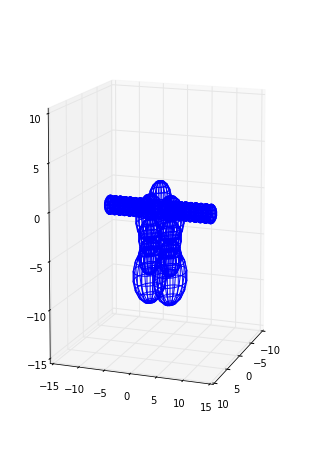

In [272]:
# approximated body using spheres for easier collision detection

centers = np.array(((0, 2, -8), (0, -2, -8), 
                   (0, 2, -6), (0, -2, -6),
                   (0, 2, -4), (0, -2, -4),
                   (0, 2, -2), (0, -2, -2), 
                   (0, 10, -1), (0, 9, -1), (0, 8, -1), (0, 7, -1), (0, 6, -1), (0, 5, -1),
                   (0, 4, -1), (0, 3, -1), (0, 2, -1), (0, 1, -1), 
                   (0, -10, -1), (0, -9, -1), (0, -8, -1), (0, -7, -1), (0, -6, -1), (0, -5, -1),
                   (0, -4, -1), (0, -3, -1), (0, -2, -1), (0, -1, -1), 
                   (0, 0, 0)))

radiuses = (3, 3, 
            2, 2, 
            2, 2,
            2.5, 2.5,
            1,1,1,1,1,1,
            1,1,1,1,
            1,1,1,1,1,1,
            1,1,1,1,
            2);



fig = plt.figure(figsize=(8, 8),dpi=80)
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

#draw sphere
for i in range(len(radiuses)):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x=radiuses[i]*np.cos(u)*np.sin(v) + centers[i][0]
    y=radiuses[i]*np.sin(u)*np.sin(v) + centers[i][1]
    z=radiuses[i]*np.cos(v) + centers[i][2]
    ax.plot_wireframe(x, y, z, color="b")

# add invisible points to set the bounds
for direction in (-1, 1):
    for point in np.diag(direction * 10 * np.array([1,1,1])):
        ax.plot([point[0]], [point[1]], [point[2]], 'w')

ax.azim = 20
ax.elev = 10





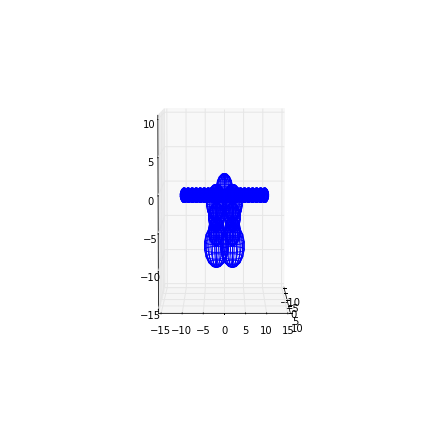
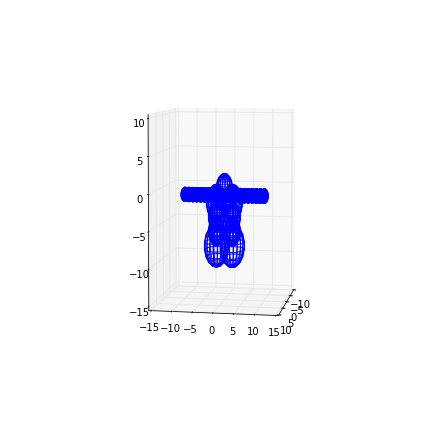
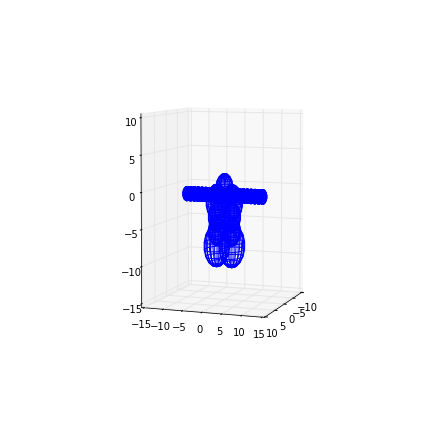
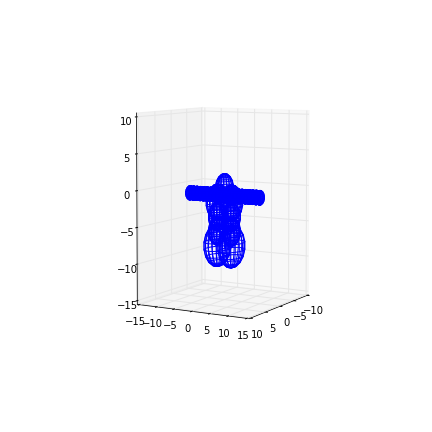
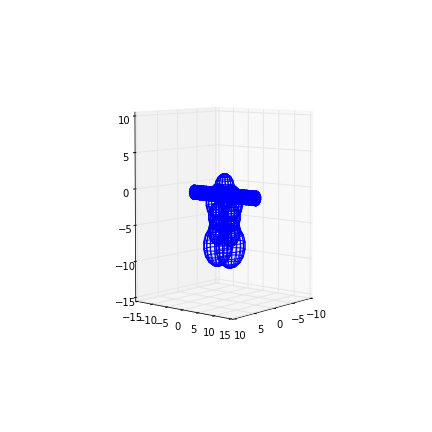
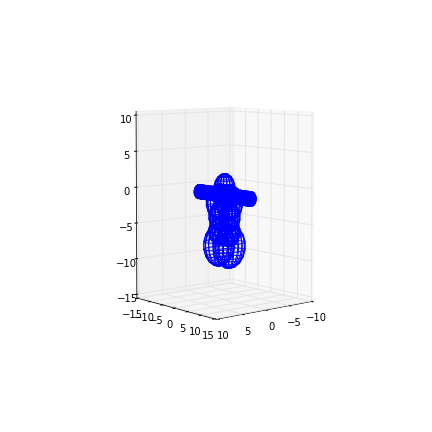
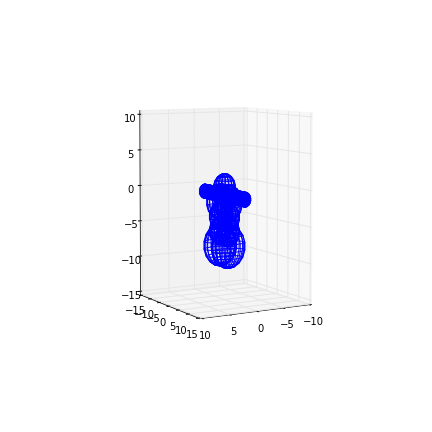
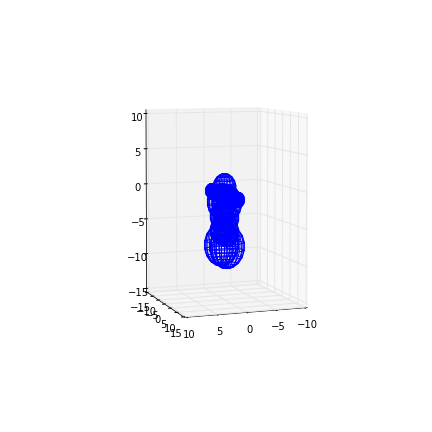
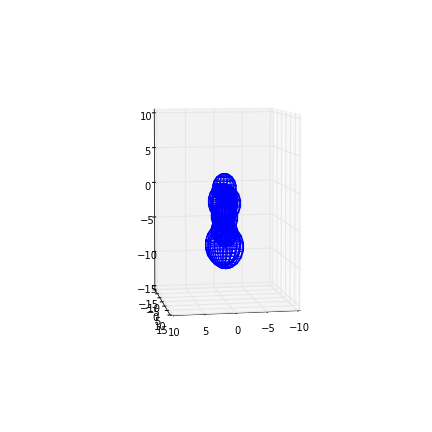
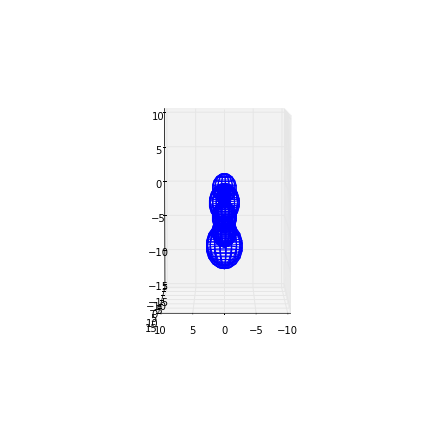
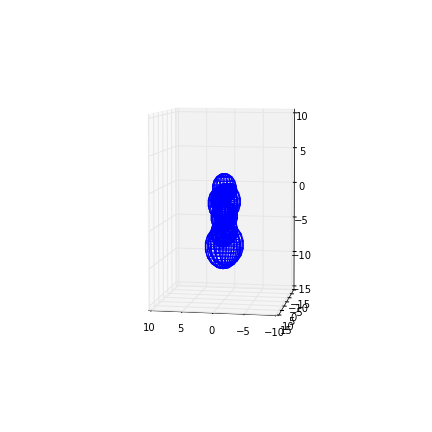
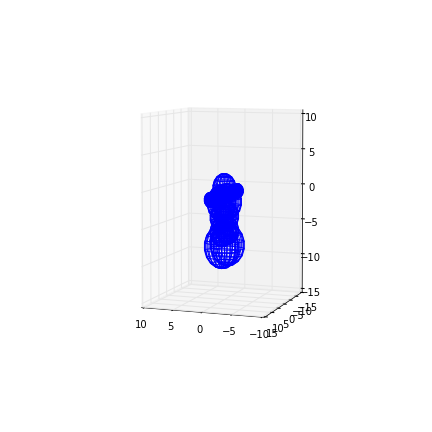
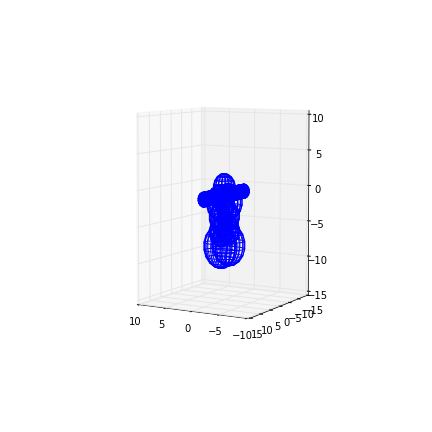
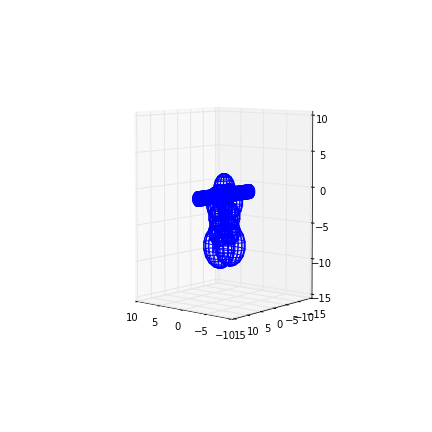
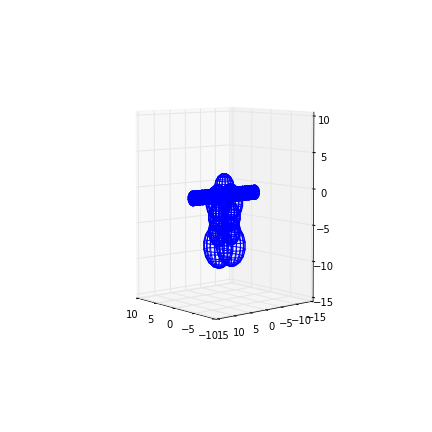
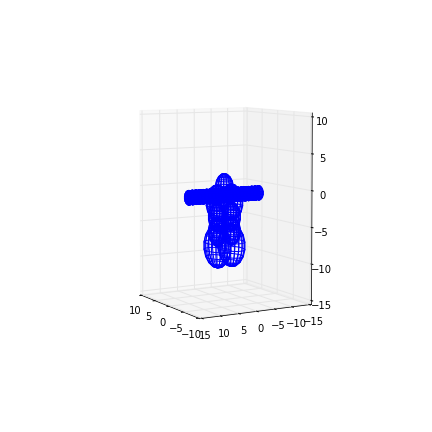
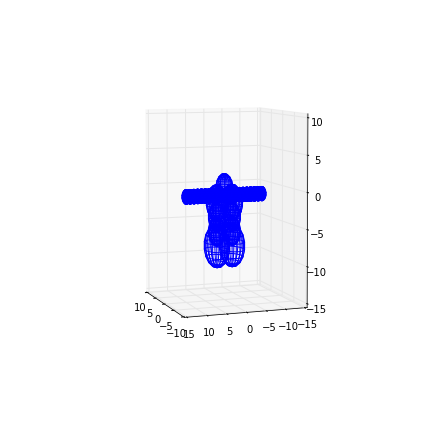
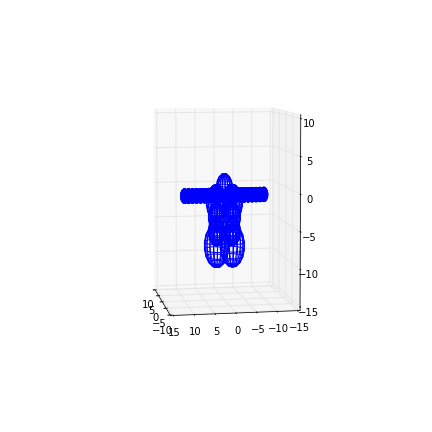
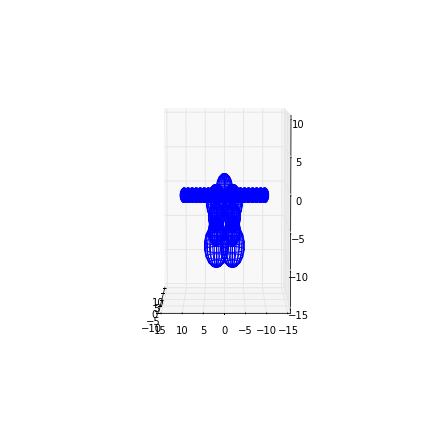
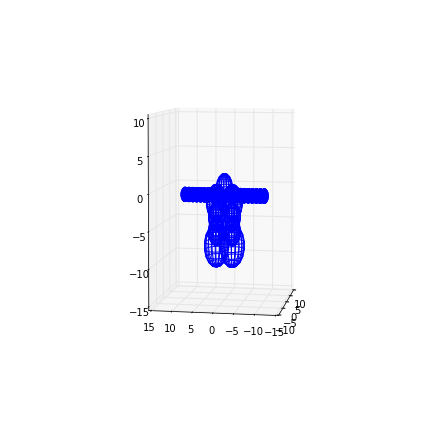
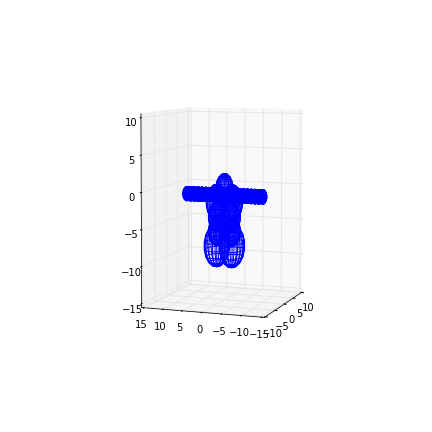
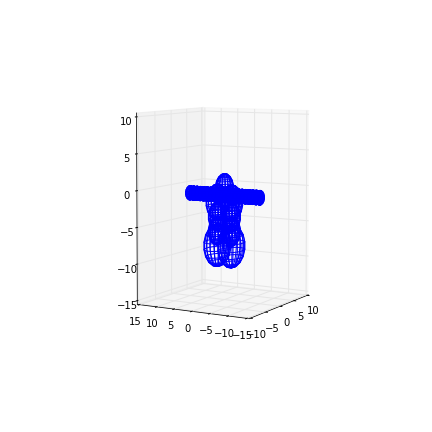
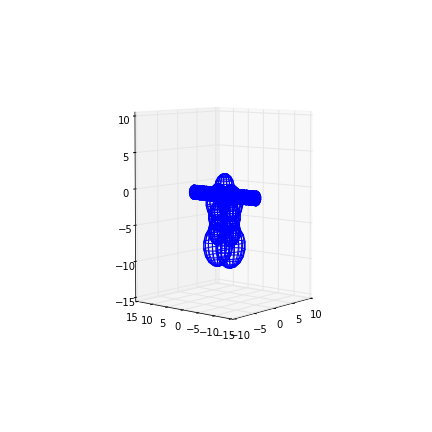
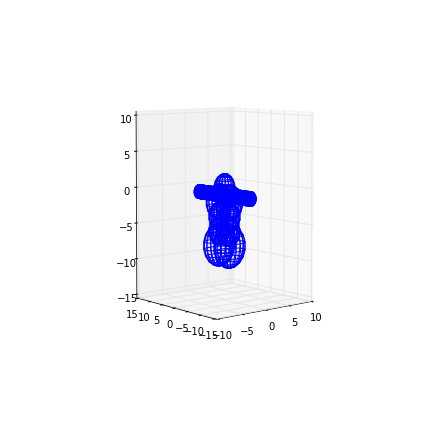
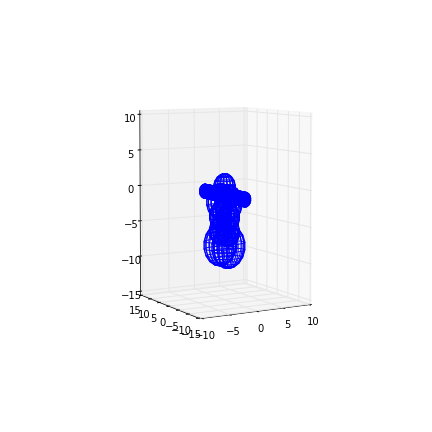
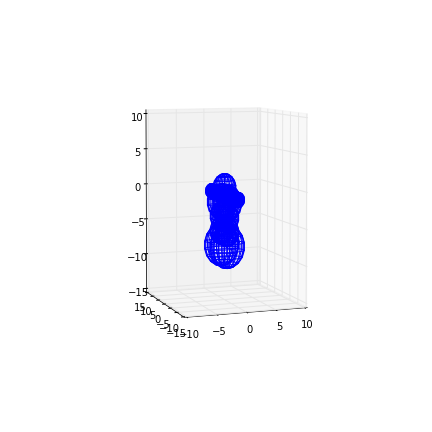
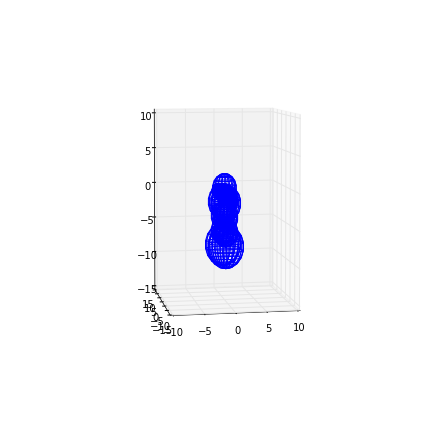
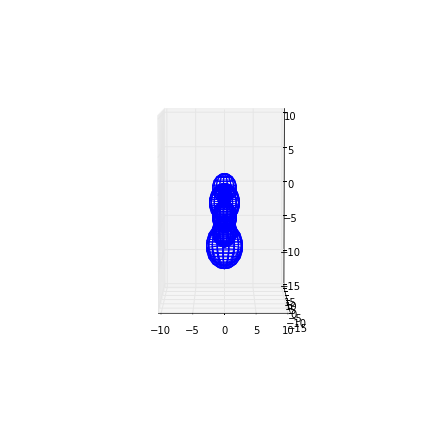
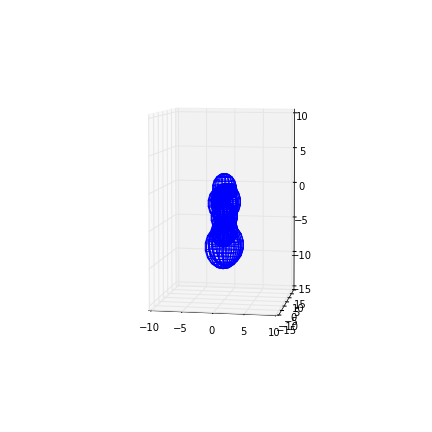
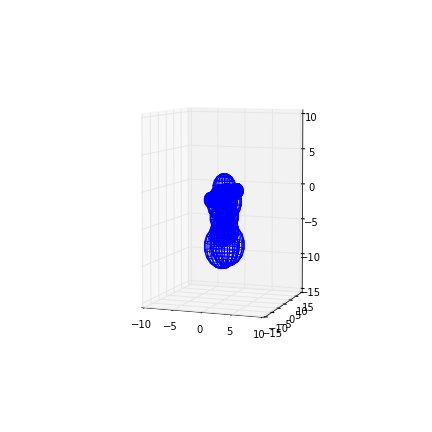
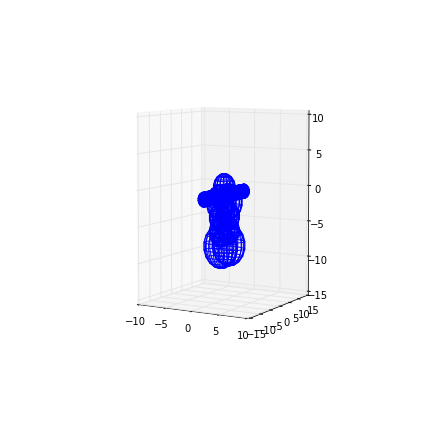
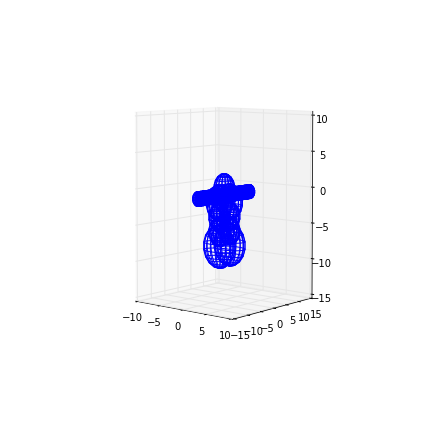
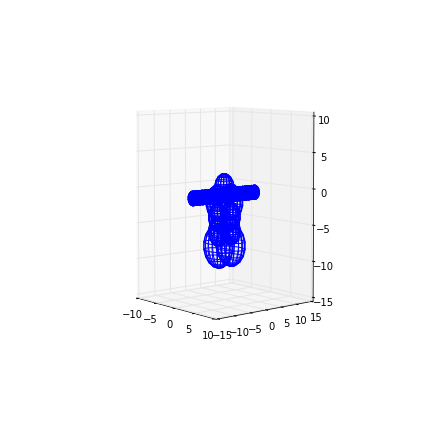
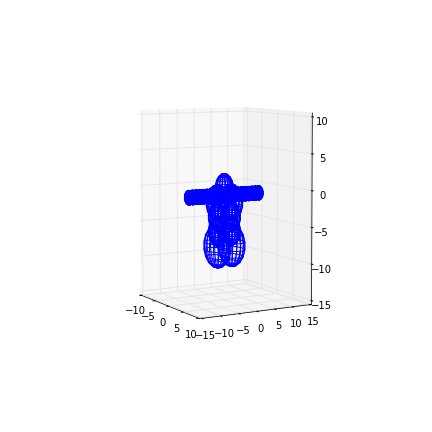
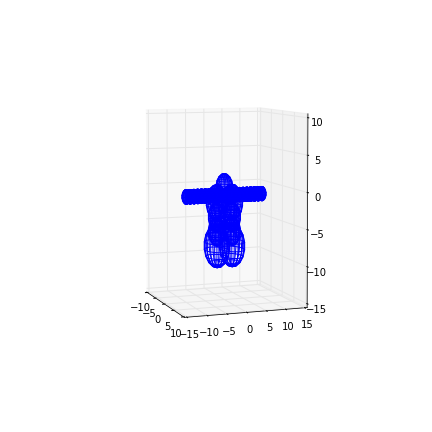

In [245]:
fig = plt.figure(figsize=(6, 6),dpi=80)
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

#draw sphere
for i in range(len(radiuses)):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x=radiuses[i]*np.cos(u)*np.sin(v) + centers[i][0]
    y=radiuses[i]*np.sin(u)*np.sin(v) + centers[i][1]
    z=radiuses[i]*np.cos(v) + centers[i][2]
    ax.plot_wireframe(x, y, z, color="b")

# add invisible points to set the bounds
for direction in (-1, 1):
    for point in np.diag(direction * 10 * np.array([1,1,1])):
        ax.plot([point[0]], [point[1]], [point[2]], 'w')
ax.azim = i*10
ax.elev = 5
        
def animateViewF(i):
    ax.azim = i*10
    ax.elev = 5
animation.FuncAnimation(fig, animateViewF,  frames=35, interval=120, blit=False)

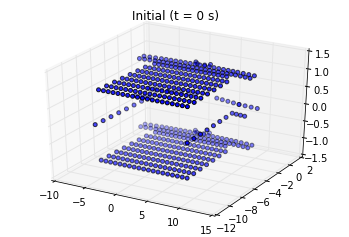

C:\Users\dave\Anaconda\lib\site-packages\IPython\kernel\__main__.py:32: RuntimeWarning: invalid value encountered in divide
C:\Users\dave\Anaconda\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: invalid value encountered in divide


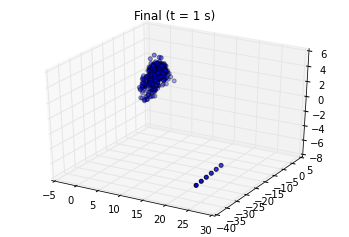

In [401]:
# 'inflate' the mesh


shoulder = np.random.normal(0, .1, 2)+np.array((-4, -.5))
sleeveBottom = np.random.normal(0, .05, 2)+np.array((-5, -2.5))
sleeveEnd = np.random.normal(0, .05, 2)+np.array((-7, -2.6))
shirtBottom = np.random.normal(0, .1, 2)+np.array((-5.5, -10))
collarMid = np.random.normal(0, .1, 2)+np.array((2, -1))
k = 100;
density = .197;    # 197 g/ m^2
dampening = 0.0005;
points = generateShirtMesh(k, density, dampening, shoulder, sleeveBottom, sleeveEnd, shirtBottom, collarMid, False);


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('Initial (t = 0 s)')
plt.show()


#  collar points are 52 / 63
points[52].anchored = True
points[63].anchored = True

inflationWeight = 3;
for point in points:
    point.applyForce(inflationWeight * np.array((point.posvel[0] * point.mass, 
                                                 (point.posvel[1]-5) * point.mass, 
                                                 point.posvel[2] * point.mass)))

simtime = 0;
timestep = 0.0001;
endtime = 1;

counter = 0;
while simtime < endtime:
    for point in points:
        point.applyConstraints(centers, radiuses);

    for point in points:
        point.update(simtime, timestep);
        
    for point in points:
        point.applyForce(np.array((inflationWeight * point.posvel[0] * point.mass, 
                                   inflationWeight * (point.posvel[1]-5) * point.mass, 
                                   inflationWeight * point.posvel[2] * point.mass) ))

    simtime = simtime + timestep;
    counter = counter + 1;
    #print counter


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('Final (t = 1 s)')
plt.show()

In [ ]:
# place mesh over body
for point in points:
        point.applyForce(np.array((0, 0, 0) ))
        # move origin of the mesh which is right collar to 0.5, 2, 0
        point.posvel[:3] = point.posvel[:3] + np.array((0.5,2,0))
        
points[52].anchored = False
points[63].anchored = False

simtime = 0;
timestep = 0.0001;
endtime = 2;

counter = 0;
while simtime < endtime:
    for point in points:
        point.applyConstraints(centers, radiuses);

    for point in points:
        point.update(simtime, timestep);
        
    for point in points:
        point.applyForce(np.array((inflationWeight * point.posvel[0] * point.mass, 
                                   inflationWeight * point.posvel[1] * point.mass, 
                                   inflationWeight * point.posvel[2] * point.mass) ))

    simtime = simtime + timestep;
    counter = counter + 1;


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('Final (t = 2 s)')
plt.show()

In [405]:
# optimize the mesh using simulated annealing
import itertools

def getAngle(particle1, originParticle, particle2):
    v1 = particle1.posvel[:3]-originParticle.posvel[:3]   # vector 1
    v2 = particle2.posvel[:3]-originParticle.posvel[:3]   # vector 2
    
    angle = np.arccos(np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)))
    if np.isnan(angle):
        if (v1_u == v2_u).all():
            return 0.0
        else:
            return np.pi
    return angle

def utility(points):
    # calculate the utility
    tension = 0
    angles = 0
    for point in points:
        numLinks = len(point.links)
        maxAngle = 0;
        for pair in itertools.product(range(numLinks), repeat=2):
            getAngle(point.links[pair[0]].particle2, point.links[pair[0]].particle1, point.links[pair[1]].particle2)
        angles = np.abs(pair[0])
        for link in point.links:
            tension += np.linalg.norm(link.getForce(self, link.particle2))
            
    
    return tension + angles

def cooling(T):
    return T * 0.8

def acceptanceP(curUtil, newUtil, T):
    if newUtil >= curUtil:
        return 1;
    else:
        return np.exp(-(newUtil - curUtil)/T)

def sa(k, density, dampening):
    # simulated annealing function, returns the best model
    T_0 = 1000;
    
    # initial state generation
    shoulder = np.random.normal(0, .1, 2)+np.array((-4, -.5))
    sleeveBottom = np.random.normal(0, .05, 2)+np.array((-5, -2.5))
    sleeveEnd = np.random.normal(0, .05, 2)+np.array((-7, -2.6))
    shirtBottom = np.random.normal(0, .1, 2)+np.array((-5.5, -10))
    collarMid = np.random.normal(0, .1, 2)+np.array((2, -1))
    
    points = generateShirtMesh(k, density, dampening, shoulder, sleeveBottom, sleeveEnd, shirtBottom, collarMid)
    oldEnergy = utility(points) 
    
    T = T_0
    while T > 25:        
        shoulder0 = np.random.normal(0, .1, 2) + shoulder
        sleeveBottom0 = np.random.normal(0, .05, 2) + sleeveBottom
        sleeveEnd0 = np.random.normal(0, .05, 2) + sleeveEnd
        shirtBottom0 = np.random.normal(0, .1, 2) + shirtBottom
        collarMid0 = np.random.normal(0, .1, 2) + collarMid
        points0 = generateShirtMesh(k, density, dampening, shoulder0, sleeveBottom0, sleeveEnd0, shirtBottom0, collarMid0)
        energy = utility(points0)                 
        if acceptanceP(curUtil, newUtil, T) > np.random.rand(1):
            # accept the proposed state
            points = points0;
            shoulder = shoulder0
            sleeveBottom = sleeveBottom0
            sleeveEnd = sleeveEnd0
            shirtBottom = shirtBottom0
            collarMid = collarMid0
        T = cooling(T)

    return (shoulder, sleeveBottom, sleeveEnd, shirtBottom, collarMid)
k = 100;
density = .197;    # 197 g/ m^2
dampening = 0.005;
sa(k, density, dampening)


In [412]:
# sample the optimization for mass and spring constant

# Monte Carlo Loop
N = 100;

shoulderHist = np.zeros((N,2))
sleeveBottomHist = np.zeros((N,2))
sleeveEndHist = np.zeros((N,2))
shirtBottomHist = np.zeros((N,2))
collarMidHist = np.zeros((N,2))

dampening = 0.005;

for i in range(N):
    mass = np.random.randn(1)*0.1 + 0.197
    k = np.random.randn(1)*10 + 100
    results = sa(k, mass, dampening)
    #results = ((0,0),(0,1),(0,2),(0,3),(0,4))
    shoulderHist[i,:] = results[0];
    sleeveBottomHist[i,:] = results[1];
    sleeveEndHist[i,:] = results[2];
    shirtBottomHist[i,:] = results[3];
    collarMidHist[i,:] = results[4];

import seaborn as sns
# look at the histogram of position
plt.figure()
h, x, y, p = plt.hist2d(collarMidHist[:,0], collarMidHist[:,1], bins = 12)
sns.kdeplot(collarMidHist, shade=True)
plt.show()


C:\Users\dave\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: RuntimeWarning: invalid value encountered in arccos


NameError: global name 'v1_u' is not defined